In [2]:
from src.model.eegnet_variance import EEGNetMultiHeaded
from pytorch_lightning.loggers import CometLogger
from src.datamodule import DataModule, predictDataSet
from src.preprocessing import create_dataset
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.preprocessing import *
from src.noise_addition import zero_signal, add_gaussian_noise
import copy
import random


In [3]:
# Load training module
# The preproccesing code is currently quite messy, still need to clean it up
train, val, test = create_dataset('./src/pickle_df', 1)


In [4]:
comet_logger = CometLogger(
    api_key="WSATCNWE43zphHslQCTsJKcgk",
    workspace="marwo22",  # Optional
    project_name="bachelors-project"  # Optional
)

CometLogger will be initialized in online mode


In [5]:
def sample_5_percent(n_channels):
    count = 0
    for _ in range(n_channels):
        if random.randint(0, 19) == 0:
            count += 1
    
    return count

In [6]:
def add_noise_to_eeg(signal, severity: int):
    random_val = random.randint(0, 2)
    channels_to_corrupt = int(64 / 10 * severity)
    if random_val == 0: # Gaussian noise
        signal = add_gaussian_noise(signal, .12 * severity, channels_to_corrupt, 0, 308)
        pass
    elif random_val == 1: # Zeroing
        samples = sample_5_percent(channels_to_corrupt)
        signal = zero_signal(signal, channels_to_corrupt - samples, percentage=0.03 * severity)
        if samples:
            signal = zero_signal(signal, samples, percentage=100)
        pass
    elif random_val == 2: # Combination of both
        channels_to_corrupt = int(channels_to_corrupt / 2)
        signal = add_gaussian_noise(signal, .12 * severity, channels_to_corrupt, 0, 308)
        samples = sample_5_percent(channels_to_corrupt)
        signal = zero_signal(signal, channels_to_corrupt - samples, percentage=0.03 * severity)
        if samples:
            signal = zero_signal(signal, samples, percentage=100)

    return signal


In [16]:
def add_noise_to_dataset(dataset, severity_index):
    if (severity_index == 0):
        return dataset

    length = len(dataset[0])
    episodes_to_corrupt = random.sample(range(0, length), int(0.02 * severity_index * length))

    for episode in episodes_to_corrupt:
        dataset[0][episode] = add_noise_to_eeg(dataset[0][episode], severity_index)

    return dataset



In [8]:
def add_gauss_noise(dataset, id):
    length = len(dataset[0])
    episodes_to_corrupt = random.sample(range(0, length), int(0.02 * id))

    for episode in episodes_to_corrupt:
        dataset[0][episode] = add_gaussian_noise(dataset[0][episode], 0.5 * id, 32 * id)

    return dataset

In [19]:
variances = [[] for _ in range(11)]

for i in range(11):
    train_copy = copy.deepcopy(train)
    val_copy = copy.deepcopy(val)
    test_copy = copy.deepcopy(test)
    train_copy = add_noise_to_training_set(train_copy, i)
    val_copy = add_noise_to_training_set(val_copy, i)
    test_copy = add_noise_to_training_set(test_copy, i)

    dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

    model = EEGNetMultiHeaded(chunk_size=308,
                            num_electrodes=64,
                            dropout=0.5,
                            kernel_1=64,
                            kernel_2=16,
                            F1=8,
                            F2=16,
                            D=2,
                            num_classes=2)

    trainer = pl.Trainer(
        max_epochs=20,
        logger=comet_logger
    )

    trainer.fit(model, datamodule=dm)

    valPredictSet = predictDataSet(test_copy)
    valPredictLoader = DataLoader(valPredictSet, batch_size=32, shuffle=False)
    output = trainer.predict(model=model, dataloaders=valPredictLoader)
        
    for batch in output:
        variances[i] += [i.item() for i in batch[1][0]]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\43a3a295943f450fbf6fa43d10d2e39b\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 79.59it/s, v_num=e39b]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 79.45it/s, v_num=e39b]

COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8620] : (6.0029377937316895, 67.51567840576172)
COMET INFO:     val_loss [1342]   : (4.1904616355896, 46.91434860229492)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 125 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict

Predicting DataLoader 0: 100%|██████████| 33/33 [00:00<00:00, 116.48it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b



Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 79.80it/s, v_num=e39b]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 79.64it/s, v_num=e39b]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b


COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8620] : (9.261701583862305, 41466.08984375)
COMET INFO:     val_loss [1342]   : (8.614631652832031, 27665.919921875)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 124 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 33/33 [00:00<00:00, 124.81it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b



Epoch 19: 100%|██████████| 431/431 [00:06<00:00, 67.76it/s, v_num=e39b]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 431/431 [00:06<00:00, 67.57it/s, v_num=e39b]

COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8620] : (5.846493721008301, 53.48628234863281)
COMET INFO:     val_loss [1342]   : (4.512910842895508, 41.765472412109375)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 124 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 33/33 [00:00<00:00, 118.70it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b



Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 76.03it/s, v_num=e39b]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 75.88it/s, v_num=e39b]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8620] : (5.767010688781738, 62.33442687988281)
COMET INFO:     val_loss [1342]   : (4.327615261077881, 51.819095611572266)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 124 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 33/33 [00:00<00:00, 132.54it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b



Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 75.34it/s, v_num=e39b]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 75.11it/s, v_num=e39b]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8620] : (6.37462043762207, 52.91114807128906)
COMET INFO:     val_loss [1342]   : (4.593045711517334, 49.75872802734375)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning


COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 124 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 33/33 [00:00<00:00, 128.70it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b



Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 78.12it/s, v_num=e39b]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 77.97it/s, v_num=e39b]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8620] : (3.8651123046875, 46.17439270019531)


COMET INFO:     val_loss [1342]   : (4.673391342163086, 49.473167419433594)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 124 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 33/33 [00:00<00:00, 116.24it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b



Epoch 19: 100%|██████████| 431/431 [00:06<00:00, 71.38it/s, v_num=e39b]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 431/431 [00:06<00:00, 71.24it/s, v_num=e39b]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8620] : (8.526762008666992, 140.65802001953125)
COMET INFO:     val_loss [1342]   : (5.337087154388428, 46.83927536010742)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 124 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 33/33 [00:00<00:00, 108.99it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b



Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 79.47it/s, v_num=e39b]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 79.34it/s, v_num=e39b]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8620] : (6.124481201171875, 52.575401306152344)
COMET INFO:     val_loss [1342]   : (4.286153316497803, 54.833370208740234)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 124 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 33/33 [00:00<00:00, 137.22it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b



Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 81.65it/s, v_num=e39b]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 81.48it/s, v_num=e39b]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8620] : (5.825737953186035, 54.482913970947266)
COMET INFO:     val_loss [1342]   : (3.98325252532959, 49.48778533935547)


COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 124 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 33/33 [00:00<00:00, 109.11it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b



Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 81.96it/s, v_num=e39b]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 81.80it/s, v_num=e39b]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8620] : (6.209499359130859, 67.07426452636719)


COMET INFO:     val_loss [1342]   : (4.378398895263672, 43.02178192138672)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 124 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 33/33 [00:00<00:00, 102.86it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b



Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 83.25it/s, v_num=e39b]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 431/431 [00:05<00:00, 83.03it/s, v_num=e39b]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/43a3a295943f450fbf6fa43d10d2e39b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8620] : (6.365045070648193, 13853.5654296875)
COMET INFO:     val_loss [1342]   : (16.49407386779785, 61.11749267578125)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 124 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 33/33 [00:00<00:00, 132.05it/s]


Text(0.5, 1.0, 'Effect of noise addition on variance')

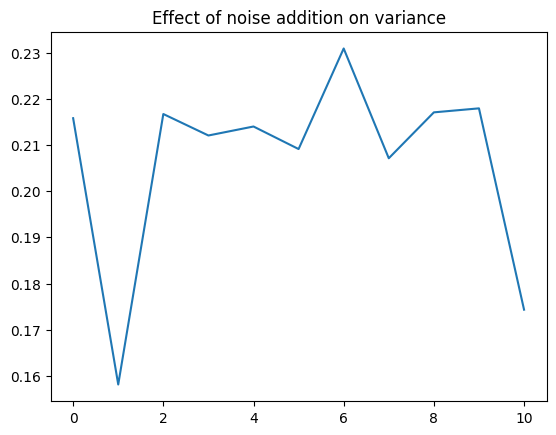

In [20]:
t = np.asarray([0, 1, 2, 3, 4, 5, 6, 7 ,8, 9, 10])

for i in range(11):
    variances[i] = np.array(variances[i]).mean()


plt.plot(t, variances)
plt.title("Effect of noise addition on variance")


In [24]:
np.array(variances[10]).mean()

0.17433805560523813

In [15]:
i = 0
train_copy = copy.deepcopy(train)
val_copy = copy.deepcopy(val)
test_copy = copy.deepcopy(test)
train_copy = add_noise_to_training_set(train_copy, i)
val_copy = add_noise_to_training_set(val_copy, i)
test_copy = add_noise_to_training_set(test_copy, i)

In [9]:
i = 0
variances2 = [[] for _ in range(11)]

dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

model = EEGNetMultiHeaded(chunk_size=308,
                        num_electrodes=64,
                        dropout=0.5,
                        kernel_1=64,
                        kernel_2=16,
                        F1=8,
                        F2=16,
                        D=2,
                        num_classes=2)

trainer = pl.Trainer(
    max_epochs=20,
    logger=comet_logger
)

trainer.fit(model, datamodule=dm)

valPredictSet = predictDataSet(test_copy)
valPredictLoader = DataLoader(valPredictSet, batch_size=32, shuffle=False)
output = trainer.predict(model=model, dataloaders=valPredictLoader)
    
for batch in output:
    variances2[i] += [i.item() for i in batch[1][0]]

NameError: name 'train_copy' is not defined

In [14]:
variances = [[] for _ in range(3)]

for i in range(3):
    train_copy = copy.deepcopy(train)
    val_copy = copy.deepcopy(val)
    test_copy = copy.deepcopy(test)

    if i != 0:
        train_copy = add_noise_to_dataset(train_copy, i * 5)
        val_copy = add_noise_to_dataset(val_copy, i * 5)
        #test_copy = add_gauss_noise(test_copy, i)
        
    dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

    model = EEGNetMultiHeaded(chunk_size=308,
                            num_electrodes=64,
                            dropout=0.5,
                            kernel_1=64,
                            kernel_2=16,
                            F1=8,
                            F2=16,
                            D=2,
                            num_classes=2)

    trainer = pl.Trainer(
        max_epochs=20,
        logger=comet_logger
    )

    trainer.fit(model, datamodule=dm)
    trainer.test(model, datamodule=dm)

    valPredictSet = predictDataSet(test_copy)
    valPredictLoader = DataLoader(valPredictSet, batch_size=32, shuffle=False)
    output = trainer.predict(model=model, dataloaders=valPredictLoader)
        
    for batch in output:
        variances[i] += [i.item() for i in batch[1][0]]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/1c27bc1b6d624165a8954b84d8c23570



Epoch 19: 100%|██████████| 432/432 [00:05<00:00, 83.63it/s, v_num=3570]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 432/432 [00:05<00:00, 83.50it/s, v_num=3570]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/1c27bc1b6d624165a8954b84d8c23570
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8640] : (5.579610824584961, 66.67921447753906)
COMET INFO:     val_loss [1362]   : (5.150886535644531, 48.69170379638672)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 257 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 93.71it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/1c27bc1b6d624165a8954b84d8c23570



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │     0.229569131321211     │
│       incorrect_var       │    0.2415651336681027     │
│         test_acc          │    0.8457854390144348     │
│         test_loss         │    12.133851051330566     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/1c27bc1b6d624165a8954b84d8c23570
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.229569131321211
COMET INFO:     incorrect_var : 0.2415651336681027
COMET INFO:     test_acc      : 0.8457854390144348
COMET INFO:     test_loss     : 12.133851051330566
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 20 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 33/33 [00:00<00:00, 115.46it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/1c27bc1b6d624165a8954b84d8c23570



Epoch 19: 100%|██████████| 432/432 [00:05<00:00, 72.34it/s, v_num=3570]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 432/432 [00:05<00:00, 72.23it/s, v_num=3570]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/1c27bc1b6d624165a8954b84d8c23570
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8640] : (5.696338653564453, 47.827659606933594)
COMET INFO:     val_loss [1362]   : (2.7081916332244873, 51.36060333251953)
COMET INFO:   Others:


COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 257 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 88.46it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/1c27bc1b6d624165a8954b84d8c23570



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 26.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21021561836493663    │
│       incorrect_var       │    0.2356177739178141     │
│         test_acc          │    0.8735632300376892     │
│         test_loss         │    10.227907180786133     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/1c27bc1b6d624165a8954b84d8c23570
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21021561836493663
COMET INFO:     incorrect_var : 0.2356177739178141
COMET INFO:     test_acc      : 0.8735632300376892
COMET INFO:     test_loss     : 10.227907180786133
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 20 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 33/33 [00:00<00:00, 95.75it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/1c27bc1b6d624165a8954b84d8c23570



Epoch 19: 100%|██████████| 432/432 [00:05<00:00, 78.23it/s, v_num=3570]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 432/432 [00:05<00:00, 78.09it/s, v_num=3570]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:


COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/1c27bc1b6d624165a8954b84d8c23570
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8640] : (8.558479309082031, 121.87354278564453)
COMET INFO:     val_loss [1362]   : (6.3605852127075195, 48.0827751159668)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 257 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 88.06it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/1c27bc1b6d624165a8954b84d8c23570



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 27.72it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.23292558817180395    │
│       incorrect_var       │    0.24152667851651166    │
│         test_acc          │    0.8409961462020874     │
│         test_loss         │    12.282970428466797     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/1c27bc1b6d624165a8954b84d8c23570
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.23292558817180395
COMET INFO:     incorrect_var : 0.24152667851651166
COMET INFO:     test_acc      : 0.8409961462020874
COMET INFO:     test_loss     : 12.282970428466797
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 20 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 33/33 [00:00<00:00, 103.86it/s]


In [13]:
np.array(variances[0]).mean()

0.2398894171823155